tf-hub BERT Layer를 이용한 분류문제

리뷰에 관한 내용이 dog에 관한 것인지, cat에 관한 것인지, 그 외인지 분류하는 문제

(from kaggle dataset)

https://ebbnflow.tistory.com/163

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!wget -q https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget -q https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget -q https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget -q https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

In [3]:
# 필요한 패키지 임포트
import os
import numpy as np
import pandas as pd
import datetime
import sys
import zipfile
import modeling
import optimization
import run_classifier
import tokenization
 
from tokenization import FullTokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
 
import tensorflow_hub as hub
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [4]:
# BERT모델과 tokenization의 파라미터 지정
sess = tf.Session()
 
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 128 #최장 토큰 길이

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 파일 로드
train_df = pd.read_csv('/content/drive/My Drive/VAIV/BERT/train/train.csv', index_col='id')
val_df = pd.read_csv('/content/drive/My Drive/VAIV/BERT/valid/valid.csv', index_col='id')
test_df = pd.read_csv('/content/drive/My Drive/VAIV/BERT/test/test.csv', index_col='id')

In [7]:
label_encoder = LabelEncoder().fit(pd.concat([train_df['label'], val_df['label']]))
#문자 label을 숫자로 encoding 시킨다.

In [8]:
X_train_val, X_test = pd.concat([train_df['text'], val_df['text']]).values, test_df['text'].values

In [9]:
y_train_val = label_encoder.fit_transform(pd.concat([train_df['label'], val_df['label']]))
#train data set에 대한 scaling

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,y_train_val, test_size=0.1, random_state=0, stratify = y_train_val
        )
#random state : data 분할 시 shuffle random seed
#stratify : 지정한 data 분할 유지, 나누어진 데이터셋도 기존 클래스 비율과 같아야 함.

In [11]:
train_text = X_train
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train
 
val_text = X_val
val_text = [' '.join(t.split()[0:max_seq_length]) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = y_val
 
test_text = X_test
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]

#join 하는 부분은 max_seq_length를 넘는 token값을 제거하기 위한 수단
#np.newaxis는 차원을 하나 추가하는 방법인데 train_text[0]으로 출력하면 dtype이, [0][0]으로 출력하면 string만 나오게끔 설정됨 (1차 => 2차원)

#아무튼 위의 과정들은 다 전처리 관련한 것임 (scaling, max_token 넘는거 빼기, 파일 형식 바꿔주기 등등)

In [12]:
X_train[0]

"I got this as a supplement for skin and coat for my dogs. I couldn't tell a differenceat all in their coat or shedding.My mom used the remainder for her dogs and said it did seem to keep fleas off."

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import re
import numpy as np
from tqdm import tqdm_notebook #진행률 모듈인 듯??
from keras import backend as K
from keras.layers import Layer

Using TensorFlow backend.


In [14]:
class BertLayer(Layer):
    
    def __init__(self, n_fine_tune_layers=10, tf_hub = None, output_representation = 'pooled_output', trainable = False, **kwargs):
        
        self.n_fine_tune_layers = n_fine_tune_layers
        self.is_trainble = trainable
        self.output_size = 768
        self.tf_hub = tf_hub
        self.output_representation = output_representation
        self.supports_masking = True
        
        super(BertLayer, self).__init__(**kwargs)
 
    def build(self, input_shape):
 
        self.bert = hub.Module(
            self.tf_hub,
            trainable=self.is_trainble,
            name="{}_module".format(self.name)
        )
        
        
        variables = list(self.bert.variable_map.values())
        if self.is_trainble:
            # 1 first remove unused layers
            trainable_vars = [var for var in variables if not "/cls/" in var.name]
            
            
            if self.output_representation == "sequence_output" or self.output_representation == "mean_pooling":
                # 1 first remove unused pooled layers
                trainable_vars = [var for var in trainable_vars if not "/pooler/" in var.name]
                
            # Select how many layers to fine tune
            trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
            
            # Add to trainable weights
            for var in trainable_vars:
                self._trainable_weights.append(var)
 
            # Add non-trainable weights
            for var in self.bert.variables:
                if var not in self._trainable_weights:
                    self._non_trainable_weights.append(var)
                
        else:
             for var in variables:
                self._non_trainable_weights.append(var)
                
 
        super(BertLayer, self).build(input_shape)
 
    def compute_mask(self, inputs, mask=None):
        
        if self.output_representation == 'sequence_output':
            inputs = [K.cast(x, dtype="bool") for x in inputs]
            mask = inputs[1]
            
            return mask
        else:
            return None
        
        
    def compute_output_shape(self, input_shape):
        if self.output_representation == "sequence_output":
            return (input_shape[0][0], input_shape[0][1], self.output_size)
        else:
            return (input_shape[0][0], self.output_size)

In [15]:
import keras
 
def build_model(max_seq_length, tf_hub, n_classes, n_fine_tune): 
    in_id = keras.layers.Input(shape=(max_seq_length,), name="input_ids") #token단위
    in_mask = keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=n_fine_tune, tf_hub = tf_hub, output_representation = 'mean_pooling', trainable = True)(bert_inputs)
    drop = keras.layers.Dropout(0.3)(bert_output)
    dense = keras.layers.Dense(256, activation='sigmoid')(drop)
    drop = keras.layers.Dropout(0.3)(dense)
    dense = keras.layers.Dense(64, activation='sigmoid')(drop)
    pred = keras.layers.Dense(n_classes, activation='softmax')(dense)
    
    model = keras.models.Model(inputs=bert_inputs, outputs=pred)
    Adam = keras.optimizers.Adam(lr = 0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam, metrics=['sparse_categorical_accuracy'])
    model.summary()
 
    return model

In [20]:
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
n_classes = len(label_encoder.classes_)
n_fine_tune_layers = 48
n_classes

6

In [21]:
model = build_model(max_seq_length, bert_path, n_classes, n_fine_tune_layers)
 
# Instantiate variables
initialize_vars(sess)

IndexError: ignored

알 수 없는 오류 발생...

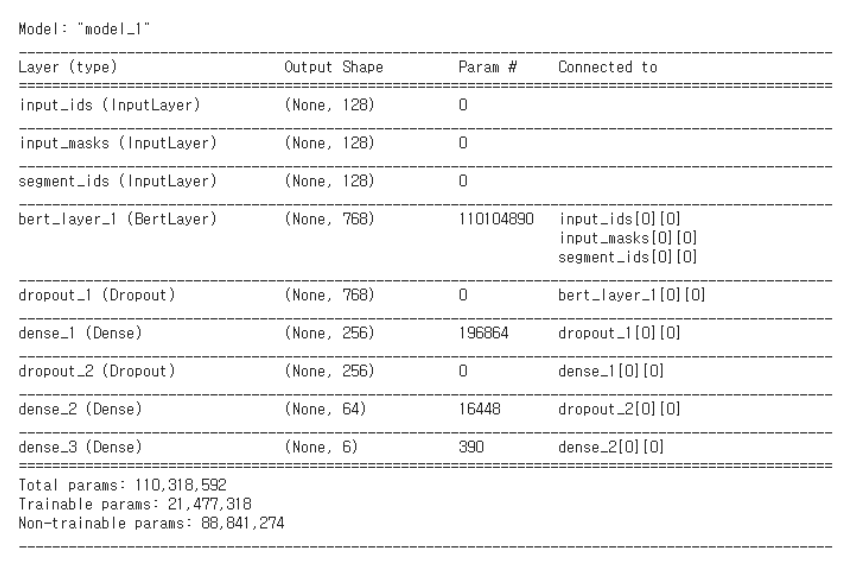

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""
 
    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
 
def create_tokenizer_from_hub_module(tf_hub):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(tf_hub)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )
    
    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label
    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    
    #print(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""
 
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )
 
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [ ]:
# 토크나이저 초기화
tokenizer = create_tokenizer_from_hub_module(bert_path)
 
# 데이터를 입력포멧으로 변환
train_examples = convert_text_to_examples(train_text, train_label)
val_examples = convert_text_to_examples(val_text, val_label)
 
# 피쳐로 변환
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(val_input_ids, val_input_masks, val_segment_ids, val_labels
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=max_seq_length)

In [ ]:
from keras.callbacks import EarlyStopping
 
BATCH_SIZE = 256
MONITOR = 'val_sparse_categorical_accuracy'
print('BATCH_SIZE is {}'.format(BATCH_SIZE))
e_stopping = EarlyStopping(monitor=MONITOR, patience=3, verbose=1, mode='max', restore_best_weights=True)
callbacks =  [e_stopping]
 
history = model.fit(
   [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data = ([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs = 10,
    verbose = 1,
    batch_size = BATCH_SIZE,
    callbacks= callbacks
)